In [1]:
import matplotlib.pyplot as plt
import numpy
import sys

sys.path.insert(0, "../lib/")

import hitDataTools
import energySpectrum3D

import tensorflow as tf


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

In [2]:
print(tf.__version__)

1.5.0


In [3]:
N = 128
spectrum = energySpectrum3D.energySpectrum3D(64, 64, 64)
spectrum_128 = energySpectrum3D.energySpectrum3D(N, N, N)

In [4]:

# file_info = ("/home/manlong/Data/HIT/output/64x64x64/Run01_0 ", 200000)
file_info = ("/home/manlong/IPython_Notebook/TEGAN/plot_spectrum/data/64x64x64/Run01_", 123000)
# file_info = ("/home/manlong/IPython_Notebook/TEGAN/plot_spectrum/data/128x128x128/Run01_", 200000)

u, v, w, p = hitDataTools.read_data(file_info)

u.shape

k, Ek = spectrum.getEnergySpectrum3D(u, v, w, nbins=None, log_binning=False)
k, Eu = spectrum.getScalarSpectrum3D(u, nbins=None, log_binning=False)


In [5]:
def parseTFRecordExample(example_proto):
    features = {'u': tf.VarLenFeature(tf.float32),
                'v': tf.VarLenFeature(tf.float32),
                'w': tf.VarLenFeature(tf.float32),
                'p': tf.VarLenFeature(tf.float32),
                'shape': tf.FixedLenFeature((3), tf.int64)}
    
    parsed_features = tf.parse_single_example(example_proto, features)
   
    shape = tf.stack(parsed_features['shape'])

    u = tf.sparse_tensor_to_dense(parsed_features['u'])
    u = tf.reshape(u,shape)

    v = tf.sparse_tensor_to_dense(parsed_features['v'])
    v = tf.reshape(v,shape)    
    
    w = tf.sparse_tensor_to_dense(parsed_features['w'])
    w = tf.reshape(w,shape)
    
    p = tf.sparse_tensor_to_dense(parsed_features['p'])
    p = tf.reshape(p,shape)
    
    _, u_var = tf.nn.moments(u, axes=[0,1,2])
    _, v_var = tf.nn.moments(v, axes=[0,1,2])
    _, w_var = tf.nn.moments(w, axes=[0,1,2])

#     u_rms = tf.sqrt( u_var + v_var + w_var )

#     u = u / u_rms
#     v = v / u_rms
#     w = w / u_rms
#     p = p / (u_rms * u_rms)
    
    element = tf.stack( [u, v, w, p], axis=3 )

    return element


next_element:      (1, 64, 64, 64, 4)


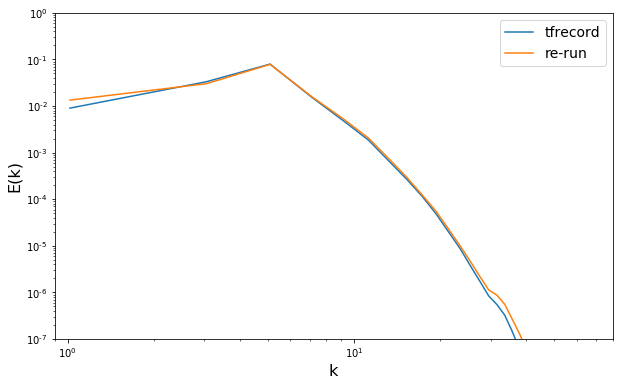

In [6]:
# dataset = tf.data.TFRecordDataset(["./data/Run01_020000.tfrecord"])
dataset = tf.data.TFRecordDataset(["/home/manlong/Data/HIT/output/64x64x64/TFRecords/test/Run01_483200.tfrecord"])
dataset = dataset.map(parseTFRecordExample)
batched_dataset = dataset.batch(4)
iterator = batched_dataset.make_one_shot_iterator()

next_element = iterator.get_next()

with tf.Session() as sess:
    ne, = sess.run([next_element])
    print("next_element:     ", ne.shape)

u_tfr = ne[0,:,:,:,0]
v_tfr = ne[0,:,:,:,1]
w_tfr = ne[0,:,:,:,2]
p_tfr = ne[0,:,:,:,3]

k_tf, Ek_tf = spectrum.getEnergySpectrum3D(u_tfr, v_tfr, w_tfr, nbins=None, log_binning=False)
k_tf, Eu_tf = spectrum.getScalarSpectrum3D(u_tfr, nbins=None, log_binning=False)

plt.figure(figsize=(10,6))
plt.loglog(k_tf, Ek_tf, label='tfrecord')
plt.loglog(k, Ek, label='re-run')
# plt.xlim(0.9, 40)
plt.xlim(0.9, 80)
plt.ylim(1.0e-7, 1)
plt.xlabel('k', fontsize=16)
plt.ylabel('E(k)', fontsize=16)
plt.legend(fontsize=14)
plt.show()


In [7]:
# u_sq = numpy.trapz(Ek, k)
# print(u_sq)
# print(numpy.mean(u**2 + v**2 +w**2))

l_0 = 2.0*numpy.pi/5.0

print(l_0)
u_rms = numpy.sqrt(numpy.mean(u**2 + v**2 +w**2)/3.0)
print(u_rms)

# nu = 0.0106913706953 # 64^3
nu = 0.00424287327 # 128^3
Re_l = numpy.sqrt(3.0/2.0)*u_rms*l_0/nu
print(Re_l)
Re_lambda = numpy.sqrt(20.0/3.0*Re_l)
print(Re_lambda)

tau_0 = l_0/u_rms
safety_factor = 1.0
# dt_mean = 0.020186780044464125 # 64^3
dt_mean = 0.008057606392238067 # 128^3
print(safety_factor*tau_0/dt_mean)
print(tau_0)


1.2566370614359172
0.3249208380419435
117.86178067394742
28.031147042049184
479.9834363916868
3.867517605238049


In [8]:
1500*1000/123845

12.111914086156082